In [37]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [38]:
data = datasets.MNIST(root='/Users/navalmor/Desktop/Image Recognition/data',
                      train=True,
                      download=True,
                      transform=transforms.ToTensor())

In [39]:
data_loader = DataLoader(dataset=data,
                         batch_size=50,
                         shuffle=True)

In [40]:
data_loader

In [41]:
class VAE(nn.Module):
    def __init__(self,
                 in_channel :int):
        super().__init__()

        self.encoder = nn.Sequential(          #-----> input size : (1, 1, 28, 28)
            nn.Conv2d(in_channels=in_channel,
                      out_channels=32,
                      kernel_size=3,
                      stride=1,
                      padding=1),              #-----> (1, 32, 28, 28)
            nn.ReLU(),
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      stride=2,
                      padding=1),              #-----> (1, 64, 14, 14)
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=2,
                      padding=1),              #-----> (1, 64, 7, 7)
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),              #-----> (1, 64, 7, 7)
            nn.ReLU(),
            nn.Flatten()                       #-----> (1, 3136)
        )

        self.mu = nn.Linear(in_features=3136,
                            out_features=2)
        self.sigma = nn.Linear(in_features=3136,
                               out_features=2)

        self.decoder = nn.Sequential(
            nn.Linear(in_features=2,
                      out_features=3136),               #------>(1, 3136)
            nn.Unflatten(dim=1,
                         unflattened_size=(64, 7, 7)),     #------->(1, 64, 7, 7)
            nn.ConvTranspose2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      output_padding=0),                 #-------->(1, 64, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=2,
                      padding=1,
                      output_padding=1),              #-----> (1, 64, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64,
                      out_channels=32,
                      kernel_size=3,
                      stride=2,
                      padding=1,
                      output_padding=1),              #-----> (1, 32, 28, 28)
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32,
                      out_channels=1,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      output_padding=0),           #-----------> (1, 1, 28, 28)
            nn.ReLU(),
            nn.Sigmoid()
        )

    def reparemeterization_trick(self, mu, sigma):
         eps = torch.randn(mu.shape[0], sigma.shape[1])
         z = mu + eps * sigma
         return z
             

    def forward(self,
                X :torch.Tensor):
          encode = self.encoder(X)
          mu = self.mu(encode)
          sigma = self.sigma(encode)
          z = self.reparemeterization_trick(mu, sigma)
          decode = self.decoder(z)
          return encode, mu, sigma, z, decode

In [42]:
model = VAE(in_channel=1)

In [43]:
encode, mu, sigma, z, decode = model(next(iter(data_loader))[0][0].unsqueeze(0))

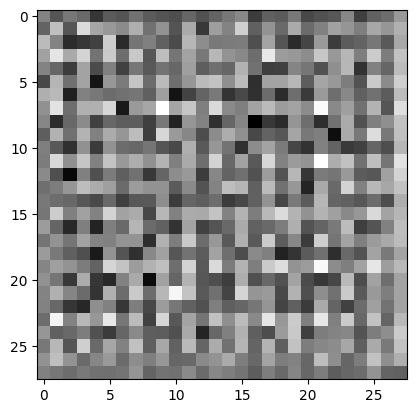

In [46]:
plt.imshow(decode.squeeze().detach(), cmap='gray')